In [3]:
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import keras
import numpy as np
import math
from keras import layers, optimizers, callbacks, preprocessing, ops
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [4]:
EPOCH = 200

train_data = preprocessing.image_dataset_from_directory(
    '/Users/rudisargueta/Documents/Alzheimer_CNN/2classes/train',   
    validation_split=.2, 
    labels='inferred', 
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32, 
    seed=1337,
    image_size=(128, 128),
    shuffle=True,
    subset='training',
)

val_data = preprocessing.image_dataset_from_directory(
    '/Users/rudisargueta/Documents/Alzheimer_CNN/2classes/train',   
    validation_split=.2, 
    labels='inferred', 
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32, 
    seed=1337,
    image_size=(128, 128),
    shuffle= True,
    subset='validation',
)


test_data = preprocessing.image_dataset_from_directory(
    '/Users/rudisargueta/Documents/Alzheimer_CNN/2classes/test',    
    labels='inferred', 
    label_mode='categorical',
    color_mode='grayscale',
   batch_size=32, 
    seed=1337,
    image_size=(128, 128),
)

class_names = ['NonDementia', 'VeryMildDementia']
train_data.class_names = class_names
val_data.class_names = class_names




Found 4352 files belonging to 2 classes.
Using 3482 files for training.
Found 4352 files belonging to 2 classes.
Using 870 files for validation.
Found 1088 files belonging to 2 classes.


2024-06-06 00:06:53.823587: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-06 00:06:53.823612: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-06 00:06:53.823615: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-06 00:06:53.823682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-06 00:06:53.823716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model = keras.models.Sequential()
model.add(layers.Input(shape=(128,128,1)))
model.add(layers.RandomFlip(mode='horizontal'))
model.add(layers.RandomZoom(0.05, fill_mode='nearest'))
model.add(layers.RandomRotation(0.05, fill_mode='nearest'))
model.add(layers.RandomTranslation(0.05, 0.05, fill_mode='nearest'))  
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(2, activation='softmax'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
optimizer = optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', 'auc', 'f1_score']
)


history = model.fit(train_data, validation_data = val_data, epochs= EPOCH)

Epoch 1/200


2024-06-06 00:06:54.539893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-06 00:06:54.933581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5029 - auc: 0.5087 - f1_score: 0.4882 - loss: 4.9221

2024-06-06 00:07:02.198284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5032 - auc: 0.5090 - f1_score: 0.4884 - loss: 4.9065 - val_accuracy: 0.6172 - val_auc: 0.6401 - val_f1_score: 0.5974 - val_loss: 0.8279
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.5603 - auc: 0.5893 - f1_score: 0.5421 - loss: 0.9518 - val_accuracy: 0.6172 - val_auc: 0.6499 - val_f1_score: 0.5675 - val_loss: 0.6583
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5846 - auc: 0.6119 - f1_score: 0.5464 - loss: 0.6902 - val_accuracy: 0.6161 - val_auc: 0.6595 - val_f1_score: 0.5357 - val_loss: 0.6541
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5879 - auc: 0.6123 - f1_score: 0.5314 - loss: 0.6847 - val_accuracy: 0.6069 - val_auc: 0.6613 - val_f1_score: 0.5189 - val_loss: 0.6540
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5871 - auc: 0.6181 - f1_score: 0.4994 - loss: 0.6732 - val_accuracy: 0.6287 - val_auc: 0.6714 - val_f1_score: 0.5938 - val_loss:

In [7]:
evaluate = model.evaluate(test_data)
print(evaluate)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6872 - auc: 0.7432 - f1_score: 0.6834 - loss: 0.5967
[0.6010923981666565, 0.670036792755127, 0.7332776784896851, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.694468 , 0.6413587], dtype=float32)>]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2024-06-06 00:29:39.593834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

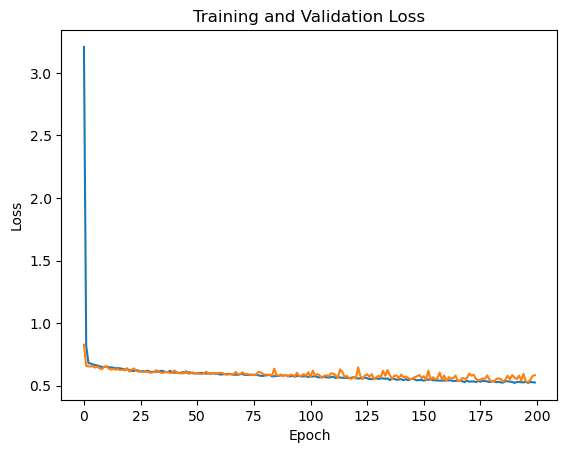

[[408 127]
 [232 321]]


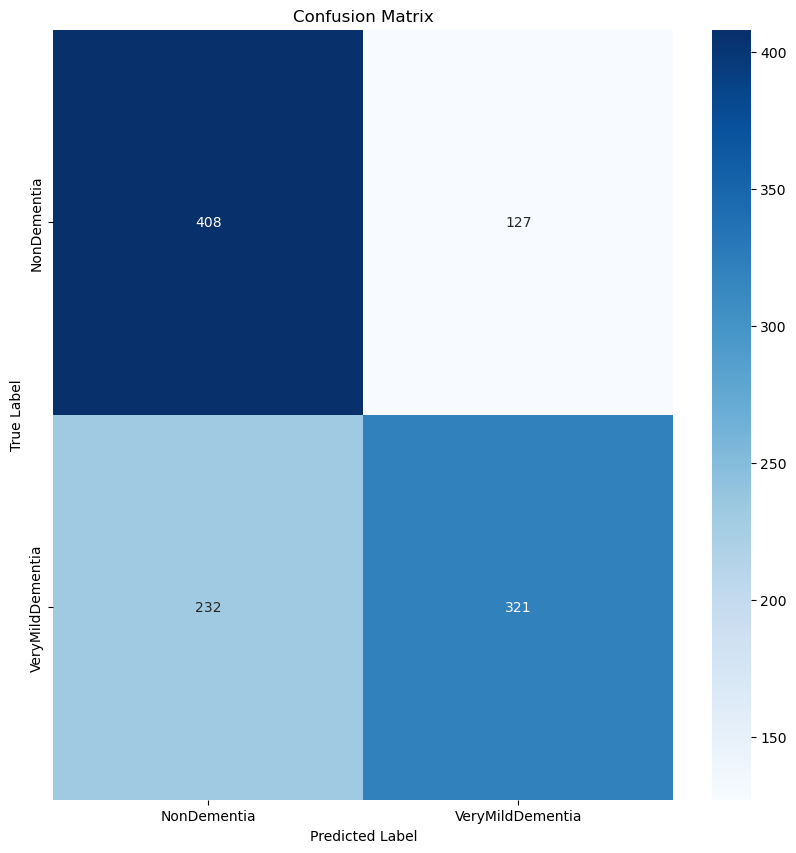

In [8]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_data:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion = confusion_matrix(predictions, labels)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Valadation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()




print(confusion)
plt.figure(figsize=(10,10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()